# Unraveling Gravitational Ripples: Neural Network Classification
### GASF vs FFT with New Data
### **GWGASF Members:** $Daniel\;Fredin^{1}$, $Cole\;Welch^{1}$, $Arif\;Chu^{1}$, $Chia-Jui\;Chou^{2}$, $Andy\;Chen^{2}$, & $Shih-Chieh\;Hsu^{1}$
#### $^{1}University\;of\;Washington,\;Seattle,\;USA$; $^{2}National\;Yang\;Ming\;Chiao\;Tung\;University,\;Hsinchu\;City,\;TW$

--------------------

In [1]:
%matplotlib inline

import numpy as np
import h5py 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler

from pyts.image import GramianAngularField

from scipy import signal
from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from timeit import default_timer as timer

# Initializes numpy and pytorch random seeds for reproducibility 
seed = 55
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Preparing the data

In [2]:
### -------------Load dataset------------- ###

# Define the file name
filename = 'classify_data.h5'

# Open the file
with h5py.File(filename, 'r') as file:
    # Load the datasets
    bbh_train = np.array(file['Training']['bbh'])
    bbh_val = np.array(file['Validation']['bbh'])
    glitch_train = np.array(file['Training']['glitch'])
    glitch_val = np.array(file['Validation']['glitch'])


### -------------Label our data as background or signal------------- ###

# Allows us to easily apply labels to our data to denote it as signal or background for classification.
anomaly_class = {
    'Glitch': 0,
    'Signal': 1
}

# ID our data as background or signal.
glitch_train_ids = np.full(glitch_train.shape[0], anomaly_class['Glitch'], dtype=int)
glitch_val_ids = np.full(glitch_val.shape[0], anomaly_class['Glitch'], dtype=int)

bbh_train_ids = np.full(bbh_train.shape[0], anomaly_class['Signal'], dtype=int)
bbh_val_ids = np.full(bbh_val.shape[0], anomaly_class['Signal'], dtype=int)



### -------------Merge dataset------------- ###

# Stick our background and signal data together for training and testing.
x_train = np.concatenate((glitch_train, bbh_train), axis=0).transpose((0,2,1))
y_train = np.concatenate((glitch_train_ids, bbh_train_ids), axis=0)

x_val_data = np.concatenate((glitch_val, bbh_val), axis=0).transpose((0,2,1))
y_val = np.concatenate((glitch_val_ids, bbh_val_ids), axis=0)



### -------------Shuffle dataset------------- ###

# Shuffle the training data using a randomly chosen permutation. This ensures we don't encounter artifacts from background 
# and signal data being clumped together.
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

#### Whitening and filtering

In [3]:
### -------------Split detector dataset------------- ###

# Each 2D dataset of gravitational wave data comes from one of two detectors: 1  and 2 
# Split the data from these two detectors since we can only pass 2D images into our CNN to train.
x_train_dec1_raw = x_train[:,:,0]
x_train_dec2_raw = x_train[:,:,1]

x_val_dec1_raw = x_val_data[:,:,0]
x_val_dec2_raw = x_val_data[:,:,1]


# Bandpass filter for 50hz and 250hz
bp = filter_design.bandpass(50, 250, 4096)

## First three harmonics of the 60 Hz AC mains power:
notches = [filter_design.notch(line, 4096) for line in (60, 120, 180)]
zpk = filter_design.concatenate_zpks(bp, *notches)

# Function to process a single item
def process_data(raw_data):
    hdata = TimeSeries(raw_data)
    hdata = hdata.whiten() 
    hdata = hdata.crop(*hdata.span.contract(1)) # The whitened timeseries data

    hfilt = hdata.filter(zpk, filtfilt=True)
    hfilt = hfilt.crop(*hfilt.span.contract(1)) # The filtered and whitened timeseries data

    return hfilt, hdata


# Process training data
x_train_dec1_data_arr = []
x_train_dec1_filt_arr = []
x_train_dec2_data_arr = []
x_train_dec2_filt_arr = []
x_val_dec1_data_arr = []
x_val_dec1_filt_arr = []
x_val_dec2_data_arr = []
x_val_dec2_filt_arr = []


for raw_data in x_train_dec1_raw:
    hdata, hfilt = process_data(raw_data)
    x_train_dec1_data_arr.append(hdata)
    x_train_dec1_filt_arr.append(hfilt)

x_train_dec1_data_arr = np.array(x_train_dec1_data_arr)
x_train_dec1_filt_arr = np.array(x_train_dec1_filt_arr)


for raw_data in x_train_dec2_raw:
    hdata, hfilt = process_data(raw_data)
    x_train_dec2_data_arr.append(hdata)
    x_train_dec2_filt_arr.append(hfilt)

x_train_dec2_data_arr = np.array(x_train_dec2_data_arr)
x_train_dec2_filt_arr = np.array(x_train_dec2_filt_arr)


for raw_data in x_val_dec1_raw:
    hdata, hfilt = process_data(raw_data)
    x_val_dec1_data_arr.append(hdata)
    x_val_dec1_filt_arr.append(hfilt)

x_val_dec1_data_arr = np.array(x_val_dec1_data_arr)
x_val_dec1_filt_arr = np.array(x_val_dec1_filt_arr)


for raw_data in x_val_dec2_raw:
    hdata, hfilt = process_data(raw_data)
    x_val_dec2_data_arr.append(hdata)
    x_val_dec2_filt_arr.append(hfilt)

x_val_dec2_data_arr = np.array(x_val_dec2_data_arr)
x_val_dec2_filt_arr = np.array(x_val_dec2_filt_arr)

## NOTE: build a timer so that we can see the progress



##### NOTE: RESTART HERE WITHOUT HAVING TO WHITEN AND FILTER

In [4]:
#### START HERE IF YOU NEED TO RESTART WITHOUT HAVING TO WHITEN AND FILTER
x_train_dec1 = x_train_dec1_filt_arr
x_train_dec2 = x_train_dec2_filt_arr
x_val_dec1 = x_val_dec1_filt_arr
x_val_dec2 = x_val_dec2_filt_arr

-----

## Converting to GASF

In [5]:
### -------------Convert dataset to GASF------------- ###

# Utilize Gramian Angular Fields to transform our image from time series to images 
# so that we can apply a CNN for classification. See for an explanation: 
# Imaging Time-Series to Improve Classification and Imputation. 
# Zhiguang Wang and Tim Oates. 
# https://arxiv.org/pdf/1506.00327

## NOTE: NEED TO HAVE USER INPUT FOR IMAGE SIZE??

gasf = GramianAngularField(image_size=129, sample_range = (-1,1), method="summation")
# Convert training data to image format
img_x_train_dec1 = gasf.transform(x_train_dec1)
img_x_train_dec2 = gasf.transform(x_train_dec2)

# Convert testing data to image format
img_x_val_dec1 = gasf.transform(x_val_dec1)
img_x_val_dec2 = gasf.transform(x_val_dec2)


# Stack Detector 1 and Detector 2 image data together to unify our training and testing datasets before training.
x_train = np.stack((img_x_train_dec1, img_x_train_dec2), axis=1)
x_val = np.stack((img_x_val_dec1, img_x_val_dec2), axis=1)

### -------------Split into training and validation datasets------------- ###

## NOTE: MAYBE USER INPUT FOR SPLIT %???

# Take the first 17.65% of our training features and targets as validation set
x_test= x_train[:round((len(x_train)*0.1072))]
y_test = y_train[:round((len(y_train)*0.1072))]

# Take the remaining 82.35% of training features and targets as training set
x_train = x_train[round((len(x_train)*0.1072)):]
y_train = y_train[round((len(y_train)*0.1072)):]

# Check the shapes of the training/validation datasets. Turns out we get about a 80%, 13%, 2% split.
print("X Training Shape: ", x_train.shape)
print("Y Training Shape: ", y_train.shape)
print("X Testing Shape: ", x_test.shape)
print("Y Testing Shape: ", y_test.shape)
print("X Validation Shape: ", x_val.shape)
print("Y Validation Shape: ", y_val.shape)


X Training Shape:  (22854, 2, 129, 129)
Y Training Shape:  (22854,)
X Validation Shape:  (598, 2, 129, 129)
Y Validation Shape:  (598,)
X Testing Shape:  (2744, 2, 129, 129)
Y Testing Shape:  (2744,)


## CNN Model

In [6]:
### -------------Model Definition------------- ###

class CNNModel(torch.nn.Module):
    
    def __init__(self):
        
        super(CNNModel, self).__init__()

                # First convolution layer (2 channel -> 16 channels, preserve original dimension by adding padding = 2) 
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=2, out_channels=16, kernel_size=5, stride=2, padding=2),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
            )
        
        # Second convolution layer (16 channel -> 32 channels, preserve dimension by adding padding = 2)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            )

        # Fully connected layer that takes the flattened output of layer 2 (32, 7 ,7) -> (1568) and output 2 classes
        self.fc1 = torch.nn.Linear(in_features=32*8*8, out_features=128)
        self.fc2 = torch.nn.Linear(in_features=128, out_features=64)
        self.fc3 = torch.nn.Linear(in_features=64, out_features=2)
    
    def forward(self, x):

        # input image -> conv -> batchnorm -> relu -> maxpool
        out = self.layer1(x)
        # 1st maxpool output -> conv -> batchnorm -> relu -> maxpool
        out = self.layer2(out)
        # flatten the second maxpool output to be used as input into FCN layer
        out = out.view(out.size(0), -1)

        # Pass flattened output into FCN layers
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

## Hyperparameters

In [7]:
### -------------Hyperparameters------------- ###

# Initialize the CNN model
model = CNNModel()
learning_rate = 0.0001      #0.00005
epochs = 40                 # 75
batchsize = 768
L2_reg = 0.001

# Define learning rate, epoch and batchsize for mini-batch gradient, and L2 regularization
# learning_rate = 0.000005
# epochs = 50
# batchsize = 768 # 768
# L2_reg = 0.00001
# L2_reg = learning_rate/epochs

# Define loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=L2_reg)

if torch.cuda.is_available():                                  # Checks if the GPU is available for processing
    model.cuda()                                               # Sends the model to the GPU for processing
model        


### -------------Identify tracked values------------- ###

train_loss_list_gasf = []
validation_accuracy_list_gasf = np.zeros((epochs,))


### -------------Creating Training Model inputs------------- ###

if torch.cuda.is_available():                   # If using CUDA version of PyTorch, dataset will be processed on GPU

    # Convert train/validation/test sets into torch tensors from numpy
    train_inputs = torch.from_numpy(x_train).float().cuda()
    train_targets = torch.from_numpy(y_train).long().cuda()

    validation_inputs = torch.from_numpy(x_val).float().cuda()
    validation_targets = torch.from_numpy(y_val).long().cuda()

    testing_inputs = torch.from_numpy(x_test).float().cuda()
    testing_targets = torch.from_numpy(y_test).long().cuda()

    # Split the training inputs/targets into mini-batches
    train_batches_features = torch.split(train_inputs, batchsize)
    train_batches_targets = torch.split(train_targets, batchsize)

else:                                           # If not using CUDA version of PyTorch, dataset will be processed on CPU

    # Convert train/validation/test sets into torch tensors from numpy
    train_inputs = torch.from_numpy(x_train).float()
    train_targets = torch.from_numpy(y_train).long()

    validation_inputs = torch.from_numpy(x_val).float()
    validation_targets = torch.from_numpy(y_val).long()

    testing_inputs = torch.from_numpy(x_test).float()
    testing_targets = torch.from_numpy(y_test).long()

    # Split the training inputs/targets into mini-batches
    train_batches_features = torch.split(train_inputs, batchsize)
    train_batches_targets = torch.split(train_targets, batchsize)

# length of train_batches_features = total number of mini-batches in the training set
batch_split_num = len(train_batches_features)

## Training loop

In [8]:
### -------------Training Loop------------- ###

for epoch in range(epochs):
    start_time = timer() # start timer
    # Each mini-batch number i, grab i-th training feature and target mini-batch and perform fwd/bwd pass on the network
    
    for i in range(batch_split_num):
    
        optimizer.zero_grad()    
        train_batch_outputs = model(train_batches_features[i])  
        loss = loss_func(train_batch_outputs, train_batches_targets[i])
        train_loss_list_gasf.append(loss.item())       
        loss.backward()
        optimizer.step()

    end_time = timer() # End timer

    with torch.no_grad():

        ### -------------Compute Validation Accuracy------------- ###
        validation_outputs = model(validation_inputs)
        val_correct = (torch.argmax(validation_outputs, dim=1) == validation_targets).type(torch.FloatTensor) 
        validation_accuracy_list_gasf[epoch] = val_correct.mean()

        print("Epoch: "+ str(epoch+1),
              "Epoch time: " + str(np.round(end_time - start_time, 2)) + "s",
              "Validation Accuracy: " + str(np.round(val_correct.mean().numpy() * 100, 2)) + '%',
              "Training loss: " + str(np.round(loss.item(), 2)), flush=True)

## NOTE: build a timer percentage bar so that we can see the progress

Epoch: 0 Epoch time: 60.75s Validation Accuracy: 81.61% Training loss: 0.5390986204147339
Epoch: 1 Epoch time: 50.1s Validation Accuracy: 83.78% Training loss: 0.5115084648132324
Epoch: 2 Epoch time: 49.66s Validation Accuracy: 84.78% Training loss: 0.49151426553726196
Epoch: 3 Epoch time: 50.94s Validation Accuracy: 87.79% Training loss: 0.4704391658306122
Epoch: 4 Epoch time: 52.09s Validation Accuracy: 87.96% Training loss: 0.4513702988624573
Epoch: 5 Epoch time: 53.84s Validation Accuracy: 87.96% Training loss: 0.43460169434547424
Epoch: 6 Epoch time: 54.89s Validation Accuracy: 88.46% Training loss: 0.41759926080703735
Epoch: 7 Epoch time: 50.81s Validation Accuracy: 89.13% Training loss: 0.40302374958992004
Epoch: 8 Epoch time: 50.15s Validation Accuracy: 89.13% Training loss: 0.3889879286289215
Epoch: 9 Epoch time: 45.98s Validation Accuracy: 89.63% Training loss: 0.3741171061992645
Epoch: 10 Epoch time: 46.35s Validation Accuracy: 90.13% Training loss: 0.3586943447589874
Epoch:

## Visualize & Evaluate Model

Training Accuracy: 91.84%
Testing Accuracy: 87.03%
Validation Accuracy: 91.47%


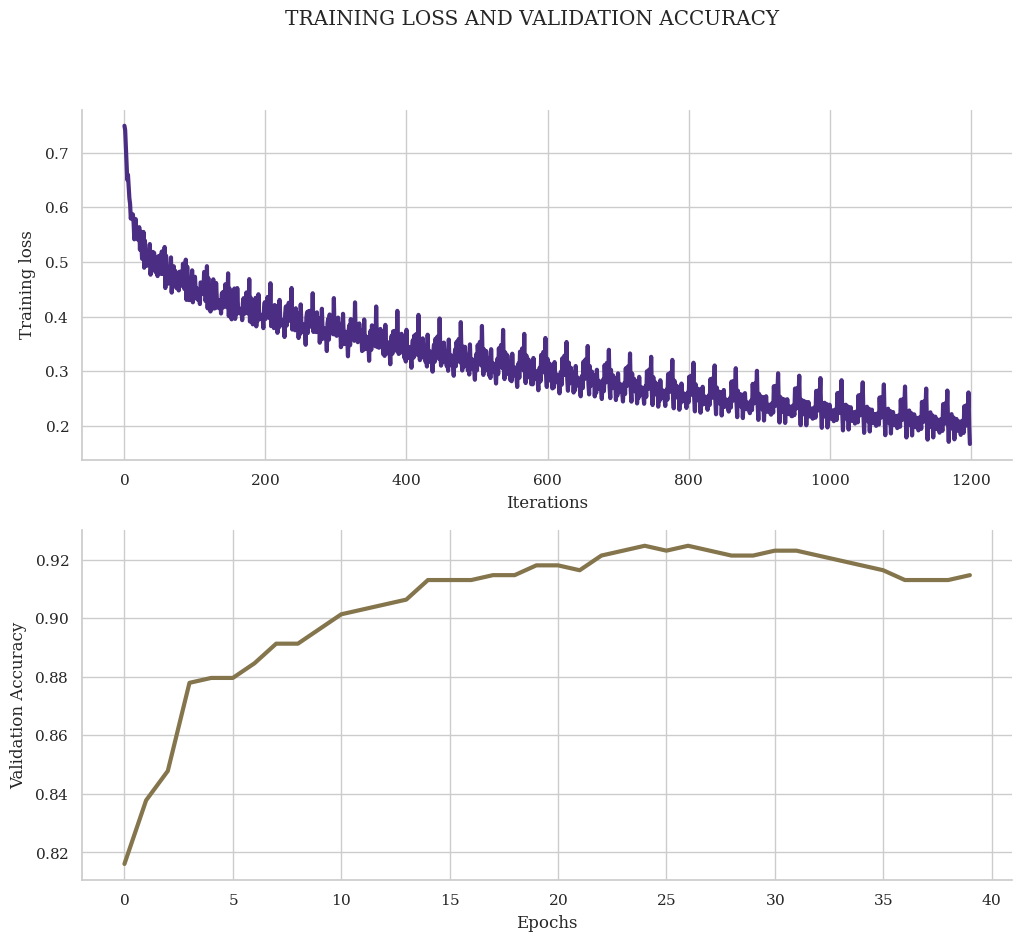

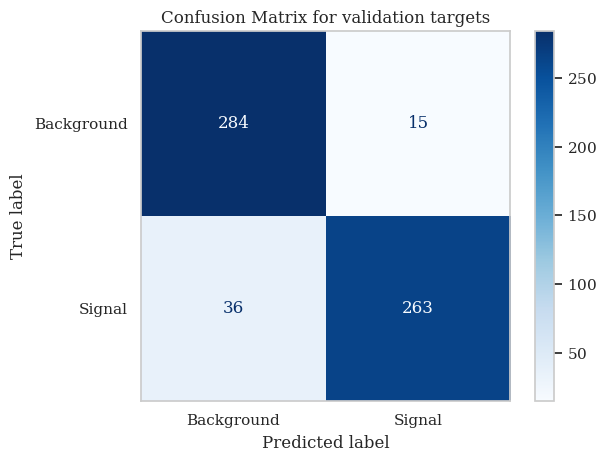

{'Accuracy': 0.9147157190635451, 'Precision': 0.9460431654676259, 'Sensitivity_recall': 0.8795986622073578, 'Specificity': 0.9498327759197325, 'F1_score': 0.9116117850953207}


In [11]:
### -------------Plot the training loss and validation accuracy------------- ###

sns.set(style = 'whitegrid', font_scale = 1)
plt.figure(figsize = (12,10))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.sans-serif"] = "Open Sans"

plt.subplot(2, 1, 1)
plt.plot(train_loss_list_gasf, linewidth = 3, color="#4b2e83")
plt.ylabel("Training loss")
plt.xlabel("Iterations")


plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list_gasf, linewidth = 3, color = "#85754d")
plt.ylabel("Validation Accuracy")
plt.xlabel("Epochs")
plt.suptitle("GASF TRAINING LOSS AND VALIDATION ACCURACY")
sns.despine()

# plt.savefig("GASF_TrainLoss_ValAcc.png")


# torch.cuda.empty_cache()

### -------------Computing the Training accuracy------------- ###

with torch.no_grad():

    target_pred_test = model(train_inputs)
    train_correct = (torch.argmax(target_pred_test, dim=1) == train_targets).type(torch.FloatTensor)
    train_testing_acc = (train_correct.mean().numpy()*100)

### -------------Computing the testing accuracy------------- ###

with torch.no_grad():

    target_pred_test = model(testing_inputs)
    test_correct = (torch.argmax(target_pred_test, dim=1) == testing_targets).type(torch.FloatTensor)
    test_testing_acc = (test_correct.mean().numpy()*100) 

### -------------Computing the validation accuracy------------- ###

with torch.no_grad():

    target_pred_test = model(validation_inputs)
    val_correct = (torch.argmax(target_pred_test, dim=1) == validation_targets).type(torch.FloatTensor)
    val_testing_acc = (val_correct.mean().numpy()*100)
    
print("Training Accuracy: {:.2f}%".format(train_testing_acc))
print("Testing Accuracy: {:.2f}%".format(test_testing_acc))
print("Validation Accuracy: {:.2f}%".format(val_testing_acc))

### -------------Confusion Matrix------------- ###

actual = validation_targets.cpu().numpy()
predicted = (torch.argmax(model(validation_inputs), dim=1)).cpu().numpy()

cm = confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(cm, 
                                            display_labels = ('Background', 'Signal'))
cm_display.plot(cmap=plt.cm.Blues, values_format = '')
plt.title('GASF Confusion Matrix for validation targets')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
plt.grid(False)
# plt.savefig("GASF_ConfMatrix.png")
plt.show()


Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted)
Sensitivity_recall = metrics.recall_score(actual, predicted)
Specificity = metrics.recall_score(actual, predicted, pos_label=0)
F1_score = metrics.f1_score(actual, predicted)
#metrics
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})


-------

## Converting to FFT

In [ ]:
# Might consider doing this to prevent crashing
# torch.cuda.empty_cache()

In [ ]:
#### START HERE IF YOU NEED TO RESTART WITHOUT HAVING TO WHITEN AND FILTER
x_train_dec1 = x_train_dec1_filt_arr
x_train_dec2 = x_train_dec2_filt_arr
x_val_dec1 = x_val_dec1_filt_arr
x_val_dec2 = x_val_dec2_filt_arr

In [ ]:
### -------------Convert to FFT Spectrograms------------- ###

data_list = []
series_list = []
Sxx_list = []
f_list = []
t_list = []
npseg=255
nolap = npseg-30

# datas = [0 ,1, 2, 3]
datas = [x_train_dec1, x_train_dec2, x_val_dec1, x_val_dec2]

for d in range(len(datas)):
    data_list = []
    series_list = []
    Sxx_list = []
    f_list = []
    t_list = []
    npseg=255
    nolap = npseg-30

    for i in range(len(datas[d])):
        data = (datas[d][i,:])
        data_list.append(data)
        # print(datas[d].shape)
        series = (TimeSeries(data, sample_rate = 4096, unit='s', name='test', t0=0))     #np.array --> constantQ.timeseries   
        series_list.append(series)

        f, t, Sxx = signal.spectrogram(series, fs = 4096, nperseg=npseg, noverlap = nolap) #return_onesided = True) 
        Sxx_list.append(Sxx)
        # f_list.append(f)
        # t_list.append(t)
        # print(d)

    if d == 0:
        data_arr_x_train_dec1 = np.stack(data_list, axis = 0)
        series_arr_x_train_dec1 = np.asarray(series_list)
        Sxx_arr_x_train_dec1 = np.stack(Sxx_list, axis = 0)

        # f_arr_x_train_dec1 = np.asarray(f_list)
        # t_arr_x_train_dec1 = np.asarray(t_list)
    elif d == 1:
        data_arr_x_train_dec2 = np.stack(data_list, axis = 0)
        series_arr_x_train_dec2 = np.asarray(series_list)
        Sxx_arr_x_train_dec2 = np.stack(Sxx_list, axis = 0)

        # f_arr_x_train_dec2 = np.asarray(f_list)
        # t_arr_x_train_dec2 = np.asarray(t_list)
    elif d == 2:
        data_arr_x_test_dec1 = np.stack(data_list, axis = 0)
        series_arr_x_test_dec1 = np.asarray(series_list)
        Sxx_arr_x_test_dec1 = np.stack(Sxx_list, axis = 0)

        # f_arr_x_test_dec1 = np.asarray(f_list)
        # t_arr_x_test_dec1 = np.asarray(t_list)
    else:
        data_arr_x_test_dec2 = np.stack(data_list, axis = 0)
        series_arr_x_test_dec2 = np.asarray(series_list)
        Sxx_arr_x_test_dec2 = np.stack(Sxx_list, axis = 0)

        # f_arr_x_test_dec2 = np.asarray(f_list)
        # t_arr_x_test_dec2 = np.asarray(t_list)




img_x_train_dec1 = Sxx_arr_x_train_dec1
img_x_train_dec2 = Sxx_arr_x_train_dec2
img_x_val_dec1 = Sxx_arr_x_test_dec1
img_x_val_dec2 = Sxx_arr_x_test_dec2




# Stack Detector 1 and Detector 2 image data together to unify our training and testing datasets before training.
x_train = np.stack((img_x_train_dec1, img_x_train_dec2), axis=1)
x_val = np.stack((img_x_val_dec1, img_x_val_dec2), axis=1)



### -------------Split into training and validation datasets------------- ###

# Take the first 17.65% of our training features and targets as validation set
x_test= x_train[:round((len(x_train)*0.1072))]
y_test = y_train[:round((len(y_train)*0.1072))]

# Take the remaining 82.35% of training features and targets as training set
x_train = x_train[round((len(x_train)*0.1072)):]
y_train = y_train[round((len(y_train)*0.1072)):]

# Check the shapes of the training/validation datasets. Turns out we get about a 80%, 13%, 2% split.
print("X Training Shape: ", x_train.shape)
print("Y Training Shape: ", y_train.shape)
print("X Validation Shape: ", x_val.shape)
print("Y Validation Shape: ", y_val.shape)
print("X Testing Shape: ", x_test.shape)
print("Y Testing Shape: ", y_test.shape)

## CNN Model

In [ ]:
### -------------Model Definition------------- ###

class CNNModel(torch.nn.Module):
    
    def __init__(self):
        
        super(CNNModel, self).__init__()

        # First convolution layer (2 channel -> 16 channels, preserve original dimension by adding padding = 2) 
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=2, out_channels=16, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=4, stride=2, padding=1)
            )
        
        # Second convolution layer (16 channel -> 32 channels, preserve dimension by adding padding = 2)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            )

        # Fully connected layer that takes the flattened output of layer 2 (32, 7 ,7) -> (1568) and output 2 classes
        self.fc1 = torch.nn.Linear(in_features=32*8*8, out_features=128)
        self.fc2 = torch.nn.Linear(in_features=128, out_features=64)
        self.fc3 = torch.nn.Linear(in_features=64, out_features=2)
    
    def forward(self, x):

        # input image -> conv -> batchnorm -> relu -> maxpool
        out = self.layer1(x)
        # 1st maxpool output -> conv -> batchnorm -> relu -> maxpool
        out = self.layer2(out)
        # flatten the second maxpool output to be used as input into FCN layer
        out = out.view(out.size(0), -1)

        # Pass flattened output into FCN layers
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

## Hyperparameters

In [ ]:
### -------------Hyperparameters------------- ###

# Initialize the CNN model
model = CNNModel()

# Define learning rate, epoch and batchsize for mini-batch gradient, and L2 regularization
learning_rate = 0.00005
epochs = 75
batchsize = 781
L2_reg = 0.001

# Define loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=L2_reg)

if torch.cuda.is_available():                                  # Checks if the GPU is available for processing
    model.cuda()                                               # Sends the model to the GPU for processing
model        



### -------------Identify tracked values------------- ###

train_loss_list_spec = []
validation_accuracy_list_spec = np.zeros((epochs,))


### -------------Training Model------------- ###

if torch.cuda.is_available():                   # If using CUDA version of PyTorch, dataset will be processed on GPU

    # Convert train/validation/test sets into torch tensors from numpy
    train_inputs = torch.from_numpy(x_train).float().cuda()
    train_targets = torch.from_numpy(y_train).long().cuda()

    validation_inputs = torch.from_numpy(x_val).float().cuda()
    validation_targets = torch.from_numpy(y_val).long().cuda()

    testing_inputs = torch.from_numpy(x_test).float().cuda()
    testing_targets = torch.from_numpy(y_test).long().cuda()

    # Split the training inputs/targets into mini-batches
    train_batches_features = torch.split(train_inputs, batchsize)
    train_batches_targets = torch.split(train_targets, batchsize)

else:                                           # If not using CUDA version of PyTorch, dataset will be processed on CPU

    # Convert train/validation/test sets into torch tensors from numpy
    train_inputs = torch.from_numpy(x_train).float()
    train_targets = torch.from_numpy(y_train).long()

    validation_inputs = torch.from_numpy(x_val).float()
    validation_targets = torch.from_numpy(y_val).long()

    testing_inputs = torch.from_numpy(x_test).float()
    testing_targets = torch.from_numpy(y_test).long()

    # Split the training inputs/targets into mini-batches
    train_batches_features = torch.split(train_inputs, batchsize)
    train_batches_targets = torch.split(train_targets, batchsize)

# length of train_batches_features = total number of mini-batches in the training set
batch_split_num = len(train_batches_features)

## Training loop

In [ ]:
### -------------Training Loop------------- ###

for epoch in range(epochs):
    
    # Each mini-batch number i, grab i-th training feature and target mini-batch and perform fwd/bwd pass on the network
    
    for i in range(batch_split_num):
    
        optimizer.zero_grad()    
        train_batch_outputs = model(train_batches_features[i])
        loss = loss_func(train_batch_outputs, train_batches_targets[i])
        train_loss_list_spec.append(loss.item())
        loss.backward()
        optimizer.step()

    ### -------------Compute Validation Accuracy------------- ###

    with torch.no_grad():

        validation_outputs = model(validation_inputs)
        val_correct = (torch.argmax(validation_outputs, dim=1) == validation_targets).type(torch.FloatTensor)                
        print("Epoch: "+ str(epoch), 
              "Validation Accuracy: " + str(np.round(val_correct.mean().numpy() * 100, 2)) + '%', flush=True)
        
        validation_accuracy_list_spec[epoch] = val_correct.mean()

## Visualize & Evaluate Model

In [ ]:
### -------------Plot the training loss and validation accuracy------------- ###

sns.set(style = 'whitegrid', font_scale = 1)
plt.figure(figsize = (12,10))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.sans-serif"] = "Open Sans"

plt.subplot(2, 1, 1)
plt.plot(train_loss_list_spec, linewidth = 3, color="#4b2e83")
plt.ylabel("Training loss")
plt.xlabel("Iterations")


plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list_spec, linewidth = 3, color = "#85754d")
plt.ylabel("Validation Accuracy")
plt.xlabel("Epochs")
plt.suptitle("TRAINING LOSS AND VALIDATION ACCURACY")
sns.despine()

# plt.savefig("trainLoss_valAcc.png")


### -------------Computing the testing accuracy------------- ###

# torch.cuda.empty_cache()
with torch.no_grad():

    target_pred_test = model(testing_inputs)
    test_correct = (torch.argmax(target_pred_test, dim=1) == testing_targets).type(torch.FloatTensor)
    testing_acc = (test_correct.mean().numpy()*100)
    
    print("Testing Accuracy: {:.2f}%".format(testing_acc))



    ### -------------Computing the Training accuracy------------- ###

# torch.cuda.empty_cache()
with torch.no_grad():

    target_pred_test = model(train_inputs)
    train_correct = (torch.argmax(target_pred_test, dim=1) == train_targets).type(torch.FloatTensor)
    testing_acc = (train_correct.mean().numpy()*100)
    
    print("Training Accuracy: {:.2f}%".format(testing_acc))


#---- Confusion Matrix ----#

actual = validation_targets.cpu().numpy()
predicted = (torch.argmax(model(validation_inputs), dim=1)).cpu().numpy()

cm = confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(cm, 
                                            display_labels = None)
cm_display.plot(cmap=plt.cm.Blues, values_format = '')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
plt.grid(False)
# plt.savefig("conf_matrix_spectrogram.png")
plt.show()


Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted)
Sensitivity_recall = metrics.recall_score(actual, predicted)
Specificity = metrics.recall_score(actual, predicted, pos_label=0)
F1_score = metrics.f1_score(actual, predicted)
#metrics
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})


In [ ]:
### -------------Plot the training loss and validation accuracy------------- ###

sns.set(style = 'whitegrid', font_scale = 1)
plt.figure(figsize = (12,10))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.sans-serif"] = "Open Sans"

plt.subplot(2, 1, 1)
plt.plot(train_loss_list_gasf, linewidth = 3, color="#4b2e83", label = 'GASF')
plt.plot(train_loss_list_spec, linewidth = 3, color="#85754d", label = 'Spectrogram')
# plt.ylabel("Training loss")
# plt.xlabel("Iterations")
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list_gasf, linewidth = 3, color = "#4b2e83", label = 'GASF')
plt.plot(validation_accuracy_list_spec, linewidth = 3, color = "#85754d", label = 'Spectrogram')
# plt.ylabel("Validation Accuracy")
# plt.xlabel("Epochs")
# plt.suptitle("TRAINING LOSS AND VALIDATION ACCURACY")
plt.legend(loc = 'lower right')
sns.despine()

# plt.savefig("trainLoss_valAcc.png")

In [ ]:
## NOTE: build a timer so that we can see the progress